## Constantes

In [6]:
DATA_DIR = '../data'
TMP_DIR = '/tmp/'

# Importación de librerías

In [43]:
import os
import zipfile
import codecs
import json
import requests
import base64
from PIL import Image
from io import BytesIO

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow import config
from keras import Sequential

In [3]:
physical_devices = config.list_physical_devices('GPU')
# logical_devices = config.list_logical_devices('GPU')

2023-01-20 19:18:45.396825: I tensorflow/stream_executor/rocm/rocm_gpu_executor.cc:838] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-20 19:18:45.462458: I tensorflow/stream_executor/rocm/rocm_gpu_executor.cc:838] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-20 19:18:45.462543: I tensorflow/stream_executor/rocm/rocm_gpu_executor.cc:838] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [4]:
## Inicialización de GPU - RX5600XT (Navi 10) - 6GB VRAM
device_memory_usage = 4096 # in MB
try:
    config.set_logical_device_configuration(
        physical_devices[0],
        [
            config.LogicalDeviceConfiguration(memory_limit=device_memory_usage),
        ]
    )
except RuntimeError as re:
    print(re)

## Carga de datos

In [11]:
file_name = 'databasesLoadData.zip'
file_path = os.path.join(DATA_DIR, file_name)
extracted = os.path.join(TMP_DIR, file_name)
with zipfile.ZipFile(file_path) as zip_ref:
    zip_ref.extractall(extracted)

### JSON

In [17]:
sign_minst_json = os.path.join(extracted, 'sign_mnist_json', 'data.json')
if not os.path.exists(sign_minst_json):
    raise Exception(f"{sign_minst_json} doesn't exist.")

data_json = []
with codecs.open(sign_minst_json, 'rU', 'utf-8') as json_file:
    for line in json_file:
        data_json.append(json.loads(line))

print(f"{len(data_json)} imágenes encontradas.")

9 imágenes encontradas.


#### Fetch data

In [18]:
images_lbls = []

for data in data_json:
    r = requests.get(data['content'])
    img = np.asarray(Image.open(BytesIO(r.content)))
    images_lbls.append((img, data['label']))

#### Visualización de datos

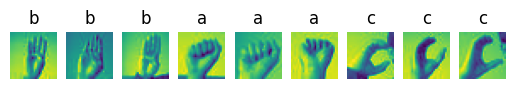

In [42]:
fig, axes = plt.subplots(1, len(images_lbls))
for img_lbl, ax in zip(images_lbls, axes):
    img, label = img_lbl
    ax.imshow(img)
    ax.set_title(label)
    ax.spines[list(ax.spines)].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])

### Bytes 64

In [59]:
sign_minst_base64 = os.path.join(extracted, 'sign_mnist_base64', 'data.json')
if not os.path.exists(sign_minst_base64):
    raise Exception(f"{sign_minst_base64} doesn't exist.")

with codecs.open(sign_minst_base64, 'r', 'utf-8') as base64_file:
    data = json.load(base64_file)
    img_base64_encoded = data['b'].encode('utf-8')

IMG_DIR = os.path.join(TMP_DIR, 'decoded_images.png')

with open(IMG_DIR, 'wb') as image_file:
    bytes_obj = base64.decodebytes(img_base64_encoded)
    image_file.write(bytes_obj)

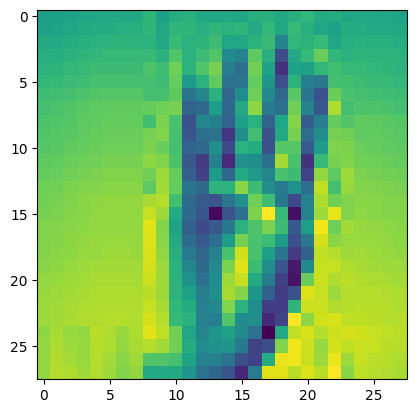

In [61]:
img = Image.open(IMG_DIR)
plt.imshow(img)
plt.show()

### CSV

In [63]:
train_url = os.path.join(extracted, "sign_mnist_train", "sign_mnist_train.csv")
test_url = os.path.join(extracted, "sign_mnist_test", "sign_mnist_test.csv")
train_df = pd.read_csv(train_url)
test_df = pd.read_csv(test_url)

In [64]:
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [65]:
,test_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,6,149,149,150,150,150,151,151,150,151,...,138,148,127,89,82,96,106,112,120,107
1,5,126,128,131,132,133,134,135,135,136,...,47,104,194,183,186,184,184,184,182,180
2,10,85,88,92,96,105,123,135,143,147,...,68,166,242,227,230,227,226,225,224,222
3,0,203,205,207,206,207,209,210,209,210,...,154,248,247,248,253,236,230,240,253,255
4,3,188,191,193,195,199,201,202,203,203,...,26,40,64,48,29,46,49,46,46,53


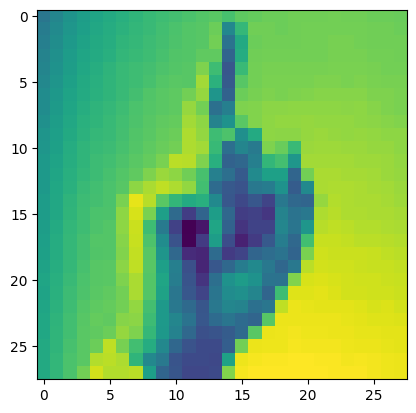

In [74]:
plt.imshow(train_df.loc[0].drop('label').to_numpy().reshape(28,28))

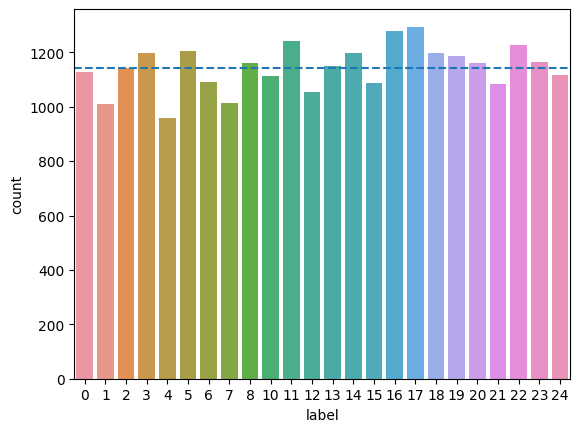

In [84]:
ax = plt.gca()
sns.countplot(train_df, x='label', ax = ax)
ax.axhline(train_df.label.value_counts().mean(), linestyle="--")
plt.show()

In [103]:
X_train = train_df.drop("label" ,axis=1)
X_test = test_df.drop("label" ,axis=1)

In [108]:
X_train.duplicated().value_counts()

False    27455
dtype: int64

In [95]:
X_train = np.reshape(train_df.drop("label" ,axis=1).to_numpy(), (-1,28,28))
X_test = np.reshape(test_df.drop("label" ,axis=1).to_numpy(), (-1,28,28))

y_train = train_df.label
y_test = test_df.label

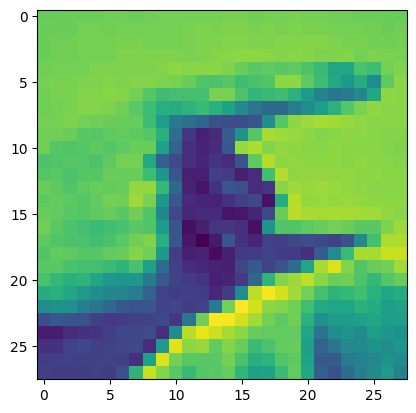

In [98]:
plt.imshow(X_test[0])